# Case study visualizations development

In [1]:
# imports
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import os
from shapely.geometry import Point
import sys  # Used for progress bar
from case_study_eval_utils import *
import datetime
import sys
import os
from io import BytesIO
plt.style.use("tableau-colorblind10")

# Import qaqc stage plot functions
sys.path.append(os.path.abspath("../scripts/3_qaqc_data"))
from qaqc_plot import flagged_timeseries_plot, _plot_format_helper, id_flag


# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"

## Step 1: Filter stations for event time and location

In [2]:
# set up event start and end dates, and affected counties
event_start_date = "2007-10-05"
event_end_date = "2007-11-30"
event_counties = ['San Diego','Los Angeles','Ventura','Santa Barbara','San Bernardino','Orange','Riverside']

In [3]:
# read in merge station list
stn_list = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

In [4]:
# convert it into geodataframe
stns_gdf = gpd.GeoDataFrame(
    stn_list,
    geometry=gpd.points_from_xy(
        stn_list.longitude, stn_list.latitude, crs="EPSG:4326"
    ),
)

In [5]:
# read in  CA county boundaries shapefile
ca_counties = gpd.read_file(
    "s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp"
)
ca_counties = ca_counties.to_crs(stns_gdf.crs)  # Convert to station CRS

In [6]:
# define the event geometry - we'll focus on one county for now (San Diego - where the largest fires occurred)
event_geom = ca_counties[ca_counties["NAME"] == ("San Diego")]  # .isin(event_counties)]

In [7]:
# filter down to stations that are in the target county
stns_gdf["intersects"] = stns_gdf.intersects(
    event_geom.unary_union
)  # See which stations intersect with the event polygon

event_stns = stns_gdf[stns_gdf["intersects"] == True].reset_index(
    drop=True
)  # Get just those stations, drop the others

In [8]:
# ...AND with start and end date within the event timeframe
event_stns = event_stns[
    (event_stns["start-date"] < event_end_date)
    & (event_stns["end-date"] > event_start_date)
]

## Step 2: Visualization

In [9]:
# take a sub sample of stations
sub_sample = find_other_events(
    event_stns, event_start_date, event_end_date, 14, 5, return_stn_ids=True
)

Subsetting station record for event duration with 14 day buffer...
5 stations selected for evaluation for comparison!
Stations selected for evaluation:
 ['CWOP_AR568', 'CIMIS_150', 'RAWS_VLCC1', 'RAWS_NPXC1', 'ASOSAWOS_74505653120']


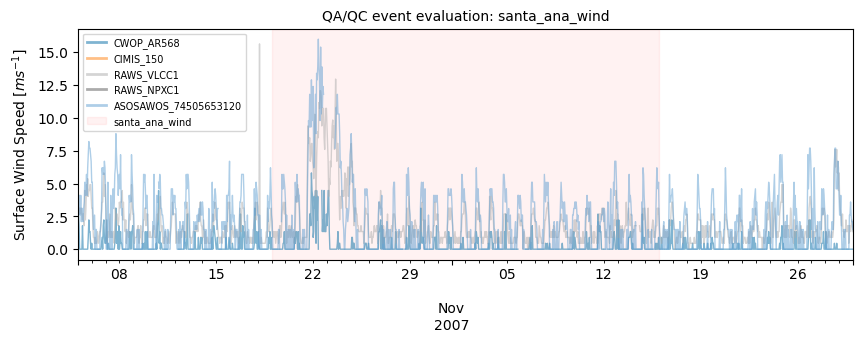

In [10]:
event_plot_multiple_stations(sub_sample, 'sfcWind', 'santa_ana_wind')

### Plotting stations that register an event signal

stations that register the event:
- CWOP_AS488
- SGXWFO_SDUSS
- CWOP_C5252
- ASOSAWOS_72290403178
- RAWS_POTC1


In [11]:
signal_list = stn_list[stn_list["era-id"].isin(
    ["CWOP_AS488", "SGXWFO_SDUSS", "CWOP_C5252"]#, "ASOSAWOS_72290403178", "RAWS_POTC1"]
)]

''	Cerulean/Blue
''	Pumpkin/Orange
'ABABAB'	Dark Gray/Gray
'595959'	Mortar/Grey
''	Picton Blue/Blue
''	Tenne (Tawny)/Orange
'898989'	Suva Grey/Grey
''	Sail/Blue
''	Macaroni And Cheese/Orange
'CFCFCF'	Very Light Grey/Grey

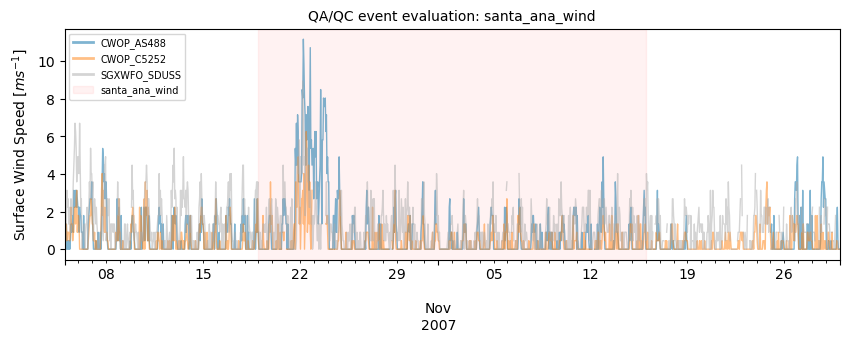

In [ ]:
event_plot_multiple_stations(signal_list, "sfcWind", "santa_ana_wind") #save_local=True, figname = 'test')